In [1]:
!pip install PyGithub
from github import Github
import pandas as pd
import numpy as np

In [2]:
gthub = Github('*** add token here ***')
repo = gthub.get_repo('twbs/bootstrap')
issues = repo.get_issues(state = 'all')

In [3]:
issues.totalCount

30155

# Analysis
For this part, the quantitative analysis for the missing fields will be conducted. In this regard, all of the attributes of a commit will be analyzed. The attributes that will be analyzed are as follows:
- Assignee
- Labels
- Projects
- Milestone 
- Linked Pull Requests
- Issue Body
---
To find the problematic issues in the repository, the events fired by the issues are used. When each of the fields are being filled, an event is fired. According to the labels of these events the problem in that particular issue has been identified. The corresponding event labels are shown in the cell below.

In [4]:
events = ('added_to_project', 'assigned', 'labeled', 'milestoned', 'review_requested') 

In [5]:
gthub.get_rate_limit().core.remaining

4998

In order to manage with the rate limiting of Github API, we implemented a conditional wait structure. By this way, we attempted to send our requests with the least amount of requests.

In [6]:
import time
import calendar
from tqdm import tqdm
def checkAndWait(github_yd):
    if github_yd.rate_limiting[0] <= 5:
        core_rate_limit = github_yd.get_rate_limit().core
        reset_timestamp = calendar.timegm(core_rate_limit.reset.timetuple())
        sleep_time = reset_timestamp - calendar.timegm(time.gmtime()) + 5  # add 5 seconds to be sure the rate limit has been reset
        for remaining in range(sleep_time, 0, -1):
            time.sleep(1)

### Counting the smells
For the counting operation of the smells, we foloowed a map like approach. As it can be seen in the next cell, there is a counter for both the issues with any problem and one for the specific problems. We looked at the events for each of the issues, and then looked for the event labels given above. The algorithm applies a conditional wait stucture, which makes the runtime efficient. However, this repository involves 30155 issues in total, which makes the runtime extremely long

In [ ]:
problematic_issues = 0
problems = np.zeros(6)
count = 1
for issue_idx in tqdm(range(issues.totalCount)):
    checkAndWait(gthub)
    issue = issues[issue_idx]
    issue_events = issue.get_events()
    count += 1
    smell = [True, True, True, True, True, True]
    for event_idx in range(issue_events.totalCount):
        checkAndWait(gthub)
        event = issue_events[event_idx]
        for label_idx in range(len(events)):
            if event.event == events[label_idx]:
                smell[label_idx] = False
    if issue.body != None:
        smell[5] = False
    for x in smell:
        if x == True:
            problematic_issues += 1
            break
    for x_idx in range(len(smell)):
        if smell[x_idx] == True:
            problems[x_idx] += 1

## Evaluation
After getting our results, we found out that every issue in twbs/bootstrap has some problem with some aspect. The illustration of this fact and the distribution of the problems are shown as plots in the next two cells.

Issues: 30155, Issues with some problem: 30155


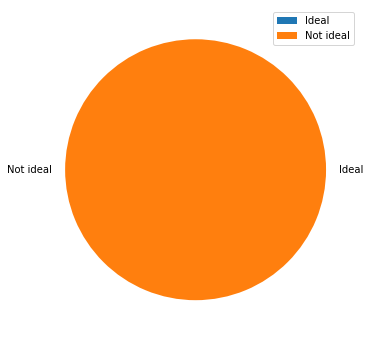

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
lb1 = ['Ideal', 'Not ideal']
print('Issues: ' + str(issues.totalCount) + ', Issues with some problem: ' + str(problematic_issues))
fig, ax = plt.subplots(figsize = (6,6))
ax.pie((issues.totalCount - problematic_issues , problematic_issues), labels = lb1)
ax.legend()

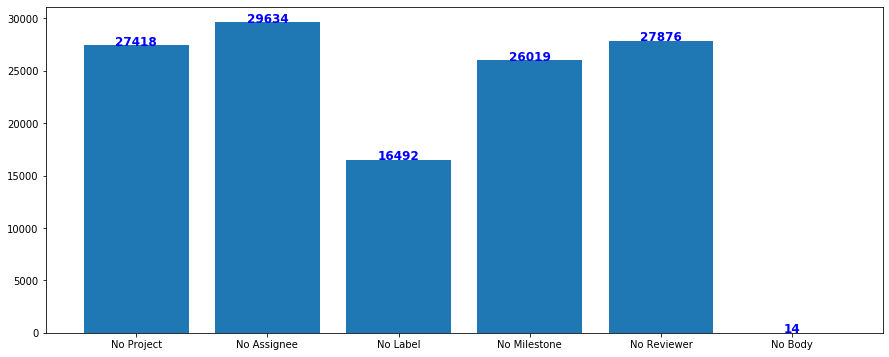

In [13]:
labels = ['No Project', 'No Assignee', 'No Label', 'No Milestone', 'No Reviewer', 'No Body']
fig,ax = plt.subplots(figsize = (15,6))
ax.bar(labels, problems)
for x_idx in range(problems.size):
    ax.text(labels[x_idx], problems[x_idx], int(problems[x_idx]), fontdict = {'family': 'sans-serif',
        'color':  'blue',
        'weight': 'heavy',
        'size': 12,
        }, ha = 'center')